In [55]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
import re

import datetime
import datetime as dt

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False

plt.rcParams['font.family'] = 'Malgun Gothic'


from lightgbm import LGBMRegressor

In [101]:
train=pd.read_csv(r'C:\Users\wngur\OneDrive\바탕 화면\Dacon\영화관객수\movies_train.csv')
test=pd.read_csv(r'C:\Users\wngur\OneDrive\바탕 화면\Dacon\영화관객수\movies_test.csv')
submisson=pd.read_csv(r'C:\Users\wngur\OneDrive\바탕 화면\Dacon\영화관객수\submission.csv')

In [102]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [103]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [104]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [105]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


<AxesSubplot:xlabel='num_staff', ylabel='box_off_num'>

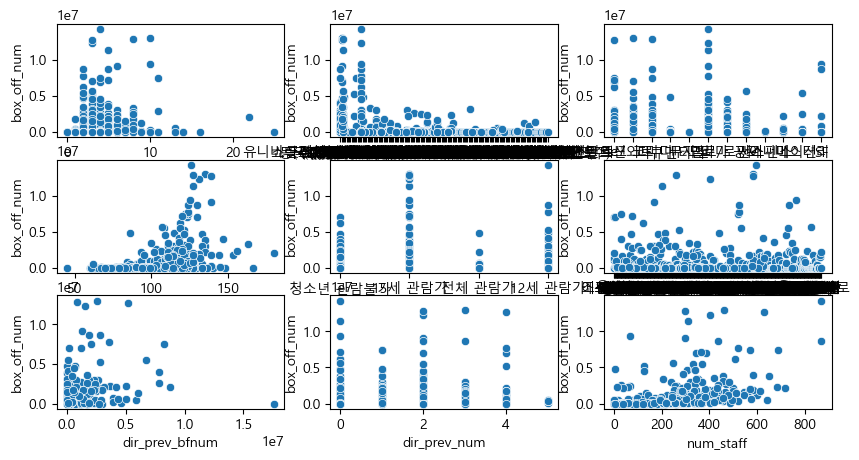

In [157]:
figure, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9))=plt.subplots(3,3)
figure.set_size_inches(10,5)

sns.scatterplot(x='num_actor',y='box_off_num',ax=ax1,data=train)
sns.scatterplot(x='distributor',y='box_off_num',ax=ax2,data=train)
sns.scatterplot(x='genre',y='box_off_num',ax=ax3,data=train)
sns.scatterplot(x='time',y='box_off_num',ax=ax4,data=train)
sns.scatterplot(x='screening_rat',y='box_off_num',ax=ax5,data=train)
sns.scatterplot(x='director',y='box_off_num',ax=ax6,data=train)
sns.scatterplot(x='dir_prev_bfnum',y='box_off_num',ax=ax7,data=train)
sns.scatterplot(x='dir_prev_num',y='box_off_num',ax=ax8,data=train)
sns.scatterplot(x='num_staff',y='box_off_num',ax=ax9,data=train)

In [106]:
# 배우의 수와 관객수는 연관 없어보임 o
# 배급사는 CJ,롯데엔터테인먼트에서 관객수 많은 경향
# 장르에 따라 관객수 차이 있어보임 
# 시간은 100분대에 관객수가 많음
# 분류에 따라 관객수 차이 존재
# 감독은 상관 없어보임
# dir 두개 결측치가 많음
# 스태프가 만으면 관객수 증가하는 경향

In [107]:
train['dir_prev_bfnum']=train['dir_prev_bfnum'].fillna(train['dir_prev_bfnum'].mean())
test['dir_prev_bfnum']=test['dir_prev_bfnum'].fillna(test['dir_prev_bfnum'].mean())

In [108]:
train['dir_prev_num']=train['dir_prev_num'].replace(0,np.NaN)
train['dir_prev_num']=train['dir_prev_num'].fillna(train['dir_prev_num'].mean())
test['dir_prev_num']=test['dir_prev_num'].replace(0,np.NaN)
test['dir_prev_num']=test['dir_prev_num'].fillna(test['dir_prev_num'].mean())

In [109]:
train.groupby('genre').sum().sort_values('box_off_num',ascending=False)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
genre,,,,,,
드라마,23128,2.124949e+08,423.518519,36351,806,138277444
코미디,5579,7.328318e+07,100.859259,11081,251,63277442
액션,3205,3.811572e+07,67.585185,9451,101,61711274
느와르,3115,2.932631e+07,50.585185,8399,97,61119768
멜로/로맨스,7538,8.795206e+07,151.029630,10591,266,33225507
공포,4209,4.473381e+07,86.911111,7408,163,24814966
SF,1318,2.029861e+07,24.792593,2565,48,23248494
미스터리,1744,1.623048e+07,32.688889,1995,49,8968319
다큐멘터리,8189,7.993162e+07,177.266667,1660,304,6247020


In [110]:
train['genre_rank'] = train.genre.map({'뮤지컬' : 1, '서스펜스' : 2, '애니메이션' : 3, '다큐멘터리' : 4, '미스터리' : 5,
                                      'SF' : 6, '공포' : 7, '멜로/로맨스' : 8, '느와르' : 9, '액션' : 10, '코미디' : 11, '드라마' : 12})
test['genre_rank'] = test.genre.map({'뮤지컬' : 1, '서스펜스' : 2, '애니메이션' : 3, '다큐멘터리' : 4, '미스터리' : 5,
                                      'SF' : 6, '공포' : 7, '멜로/로맨스' : 8, '느와르' : 9, '액션' : 10, '코미디' : 11, '드라마' : 12})

In [111]:
train.groupby('screening_rat').box_off_num.mean().sort_values(ascending=False)

screening_rat
15세 관람가     1.247519e+06
12세 관람가     8.449809e+05
청소년 관람불가    3.641813e+05
전체 관람가      1.351005e+05
Name: box_off_num, dtype: float64

In [112]:
train['screening_rat_rank'] = train.screening_rat.map({'15세 관람가' : 1, '12세 관람가' : 2, '청소년 관람불가' : 3, '전체 관람가' : 4})
test['screening_rat_rank'] = test.screening_rat.map({'15세 관람가' : 1, '12세 관람가' : 2, '청소년 관람불가' : 3, '전체 관람가' : 4})

In [113]:
dat=[]
for i in range(train.shape[0]):
    date=datetime.datetime.strptime(train['release_time'][i], '%Y-%m-%d')
    dat.append(date)
train['날짜']=dat
train['year']=train['날짜'].dt.year
train['month']=train['날짜'].dt.month
train['day']=train['날짜'].dt.day
    

In [114]:
dat=[]
for i in range(test.shape[0]):
    date=datetime.datetime.strptime(test['release_time'][i], '%Y-%m-%d')
    dat.append(date)
test['날짜']=dat
test['year']=test['날짜'].dt.year
test['month']=test['날짜'].dt.month
test['day']=test['날짜'].dt.day
    

<AxesSubplot:xlabel='day', ylabel='box_off_num'>

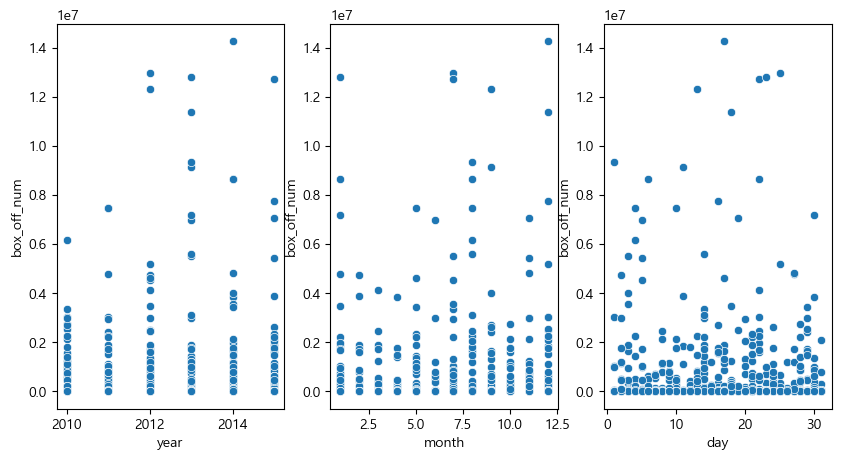

In [115]:
figure, (ax1,ax2,ax3)=plt.subplots(1,3)
figure.set_size_inches(10,5)

sns.scatterplot(x='year',y='box_off_num',ax=ax1,data=train)
sns.scatterplot(x='month',y='box_off_num',ax=ax2,data=train)
sns.scatterplot(x='day',y='box_off_num',ax=ax3,data=train)

In [116]:
train.groupby('year').mean().sort_values('box_off_num',ascending=False)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_rank,screening_rat_rank,month,day
year,,,,,,,,,,
2013,101.505263,8.855936e+05,1.867992,114.284211,3.800000,1.007358e+06,8.705263,2.315789,7.347368,17.526316
2012,101.295455,8.813591e+05,1.919024,136.579545,3.465909,9.457252e+05,9.261364,1.886364,6.568182,16.738636
2011,101.600000,1.170514e+06,1.878796,133.637500,3.737500,6.288671e+05,8.587500,2.287500,6.775000,15.250000
2015,100.258333,1.247256e+06,2.181975,163.041667,3.450000,5.958692e+05,8.575000,2.433333,7.316667,16.983333
2014,98.645669,9.467819e+05,1.885214,154.393701,3.543307,5.938845e+05,8.527559,2.417323,6.976378,15.952756
2010,103.044444,1.166907e+06,1.899918,199.233333,4.388889,5.416582e+05,9.355556,2.422222,6.944444,16.744444


In [117]:
train['year_rank'] = train.year.map({2010 : 1, 2014 : 2, 2015 : 3, 2011 : 4, 2012 : 5,
                                      2013 : 6})
test['year_rank'] = test.year.map({2010 : 1, 2014 : 2, 2015 : 3, 2011 : 4, 2012 : 5,
                                      2013 : 6})

In [118]:
train.groupby('month').mean().sort_values('box_off_num',ascending=False)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_rank,screening_rat_rank,year,day,year_rank
month,,,,,,,,,,,
1,105.205128,1.181202e+06,2.051662,213.000000,3.205128,1.365931e+06,9.615385,2.128205,2012.743590,18.794872,3.025641
12,105.122449,1.353750e+06,2.112169,184.306122,3.938776,1.288248e+06,8.959184,2.244898,2012.959184,13.897959,3.183673
7,96.775510,1.063742e+06,1.908088,124.142857,4.163265,1.113807e+06,8.346939,2.306122,2012.755102,16.244898,3.428571
8,101.218182,9.757497e+05,1.988956,177.254545,4.163636,1.029162e+06,7.890909,2.527273,2012.854545,17.054545,3.672727
9,99.550000,1.299152e+06,1.790741,124.233333,3.833333,7.315286e+05,9.150000,2.283333,2012.500000,14.116667,3.233333
2,106.741935,1.025539e+06,1.939307,163.838710,4.419355,6.630252e+05,9.387097,1.967742,2012.645161,16.806452,3.451613
5,103.526316,1.031480e+06,1.900715,145.614035,3.807018,5.756852e+05,9.508772,2.526316,2012.491228,18.684211,3.280702
6,100.379310,8.981160e+05,2.069476,113.000000,3.517241,5.122865e+05,8.655172,1.965517,2012.620690,16.482759,3.689655
11,101.597222,1.100984e+06,1.930247,147.291667,3.250000,4.956539e+05,8.736111,2.347222,2012.736111,17.152778,3.652778


In [119]:
train['month_rank'] = train.month.map({4 : 1, 3 : 2, 10 : 3, 11 : 4, 6 : 5,
                                      5 : 6,2 : 7, 9 : 8, 8 : 9, 7 : 10, 12 : 11, 1 : 12})
test['month_rank'] = test.month.map({4 : 1, 3 : 2, 10 : 3, 11 : 4, 6 : 5,
                                      5 : 6,2 : 7, 9 : 8, 8 : 9, 7 : 10, 12 : 11, 1 : 12})

In [120]:
train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')
train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

C:\Users\wngur\AppData\Local\Temp\ipykernel_4708\772443844.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['distributor'] = train.distributor.str.replace("(주)", '')
C:\Users\wngur\AppData\Local\Temp\ipykernel_4708\772443844.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['distributor'] = test.distributor.str.replace("(주)", '')


In [121]:
def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [122]:
train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

In [123]:
dist_rank=train.groupby('distributor').box_off_num.mean().reset_index(name='distributor_rank').sort_values('distributor_rank')
dist_rank['distributor_rank'] = [i + 1 for i in range(dist_rank.shape[0])]
train=pd.merge(train,dist_rank,how='left',on='distributor')
test=pd.merge(test,dist_rank,how='left',on='distributor')

In [125]:
# features=['time','dir_prev_bfnum','dir_prev_num','num_staff','num_actor','genre_rank','screening_rat_rank','year_rank','month_rank','distributor_rank']
# target=['box_off_num']

In [126]:
train['num_actor']=np.log1p(train['num_actor'])
test['num_actor']=np.log1p(test['num_actor'])

train['box_off_num']=np.log1p(train['box_off_num'])

In [129]:
features=['time','dir_prev_bfnum','dir_prev_num','num_staff','genre_rank','screening_rat_rank','month_rank','distributor_rank']
target=['box_off_num']

In [130]:
X_train,X_test,Y_train=train[features],test[features],train[target]

In [131]:
from sklearn.model_selection import KFold
import lightgbm as lgb
model=lgb.LGBMRegressor(random_state=777,n_estimators=1000)

In [132]:
k_fold=KFold(n_splits=10,shuffle=True,random_state=777)
models=[]
for train_idx, val_idx in k_fold.split(X_train):
    x_t=X_train.iloc[train_idx]
    y_t=Y_train.iloc[train_idx]
    x_val=X_train.iloc[val_idx]
    y_val=Y_train.iloc[val_idx]
    
    models.append(model.fit(x_t,y_t,eval_set=(x_val,y_val),early_stopping_rounds=100,verbose=100))

C:\Users\wngur\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\wngur\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 3.46747
[100]	valid_0's l2: 1.72532
[100]	valid_0's l2: 2.82681
[100]	valid_0's l2: 2.14492
[100]	valid_0's l2: 4.08295
[100]	valid_0's l2: 2.15852
[100]	valid_0's l2: 3.12571
[100]	valid_0's l2: 2.25865
[100]	valid_0's l2: 2.90073
[100]	valid_0's l2: 1.80194


In [133]:
preds=[]
for model in models:
    preds.append(model.predict(X_test))
len(preds)    

10

In [134]:
kfoldlight=submisson.copy()

In [135]:
kfoldlight['box_off_num']=np.mean(preds,axis=0)

In [ ]:
kfoldlight['box_off_num']=np.exp(kfoldlight['box_off_num'])

In [136]:
kfoldlight.to_csv('sub.csv',index=False,encoding='utf-8-sig')

<AxesSubplot:>

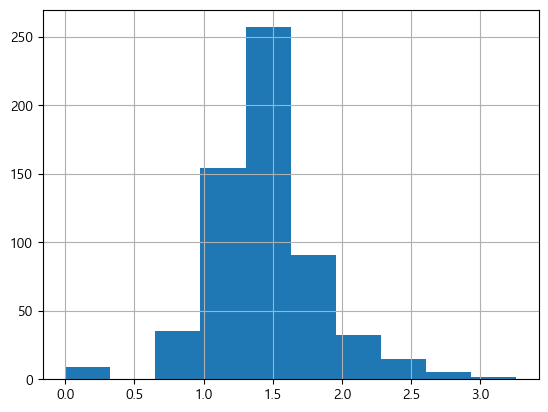

In [139]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

train['num_actor'].hist()